# Практическая работа №7. Создание и использование генеративных противоречивых примеров (GAN-based adversarial examples)

Выполнил Сердюков Матвей, ББМО-01-23

## Цель задания

Изучить использование генеративных моделей (GAN — Generative Adversarial Networks) для
создания противоречивых примеров. В этом задании мы создадим противоречивые примеры с
использованием GAN и проверим их влияние на модели классификации.

## Задачи:

1. Изучить концепцию генеративных противоречивых примеров.
2. Реализовать простую GAN для создания противоречивых изображений.
3. Оценить точность моделей классификации на противоречивых примерах, созданных с
помощью GAN.
4. Сравнить атаку на обе модели (полносвязную и свёрточную сети).

## Создание простой GAN для генерации противоречивых примеров

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0

# Добавление одного измерения (для работы CNN)
train_images = np.expand_dims(train_images, axis=-1)

# Генератор
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Дискриминатор
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Создание моделей
generator = build_generator()
discriminator = build_discriminator()

# Компиляция дискриминатора
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Создание GAN
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Функция обучения GAN
def train_gan(generator, discriminator, gan, epochs=500, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Обучение дискриминатора
        idx = np.random.randint(0, train_images.shape[0], half_batch)
        real_images = train_images[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        # Обучение генератора через дискриминатор
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)
        if epoch % 100 == 0:
            print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')
# Обучение GAN
train_gan(generator, discriminator, gan)

2024-12-20 21:28:44.358106: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 21:28:44.527925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 21:28:44.596962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 21:28:44.615778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 21:28:44.737621: I tensorflow/core/platform/cpu_feature_guar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


/home/baksist/.virtualenvs/aszii/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [0.68168676 0.78125   ]] [G loss: [array(0.6739826, dtype=float32), array(0.6739826, dtype=float32), array(0.84375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-12-20 21:28:48.814630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/functional_10_1/sequential_1_2/leaky_re_lu_1_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/functional_10_1/sequential_1_2/conv2d_1/add'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

2024-12-20 21:29:48.937240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/functional_10_1/sequential_1_2/leaky_re_lu_1_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/functional_10_1/sequential_1_2/conv2d_1/add'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

2024-12-20 21:30:48.970450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/functional_10_1/sequential_1_2/leaky_re_lu_1_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/functional_10_1/sequential_1_2/conv2d_1/add'.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
400 [D loss: [1.9978576  0.30131015]] [G loss: [array(1.9989219, dtype=float32), array(1.9989219, dtype=float32), array(0.3011222, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━

## Генерация противоречивых примеров примеров с помощью GAN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


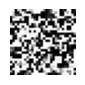

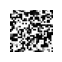

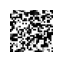

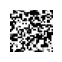

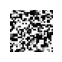

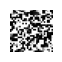

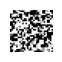

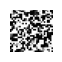

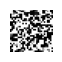

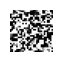

In [2]:
# Генерация противоречивых примеров
def generate_adversarial_examples(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, 100))
    generated_images = generator.predict(noise)
    return generated_images

# Генерация 100 примеров
adversarial_images = generate_adversarial_examples(generator, 100)

# Визуализация противоречивых примеров
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

## Оценка моделей на противоречивых примерах

In [3]:
# Загрузка обученных моделей
model1 = tf.keras.models.load_model('../prz-6/mnist_model1.h5')
model2 = tf.keras.models.load_model('../prz-6/mnist_model2.h5')

# Оценка первой модели на противоречивых примерах
adv_images_reshaped = adversarial_images.reshape(-1, 28, 28, 1)
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10))) # Примерные метки
print(f'Accuracy of model1 on adversarial GAN examples: {acc1}')

# Оценка второй модели на противоречивых примерах
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10))) # Примерные метки
print(f'Accuracy of model2 on adversarial GAN examples: {acc2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 290.5544  
Accuracy of model1 on adversarial GAN examples: 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 598.7330  
Accuracy of model2 on adversarial GAN examples: 0.0


## Вывод

В результате применения противоречивых примеров, созданных с помощью GAN, обе модели полностью потеряли возможность классифицировать изображения (точность упала до 0), что говорит о высокой уязвимости этих моделей к данному типу атак.